In [1]:
import glob
import pandas as pd
from Bio import SeqIO
from gzip import open as gopen
from collections import Counter

### Cut and merge the 16rRNA reads

In [10]:
!mkdir -p cut_reads/16SrRNA

for f in glob.glob('raw_data/16SrRNA/AS*_S*_L001_R*_001.fastq.gz'):
    outf = 'cut_reads/16SrRNA/%s' % f.split('/')[-1]
    smpl = f.split('/')[-1].split('_')[0]
    records = SeqIO.parse(gopen(f,'rt'),'fastq')
    with gopen(outf,'wt') as hndl:
        for r in records:
            
            # Bad sequences have monomorphic ends.
            # I skip sequences that were close to monomorphic in the last
            # 40 base pairs
            counts = Counter(str(r[110:150].seq).upper())
            proportions = {i: counts[i]/sum(counts.values()) for i in counts.keys()}
            if any([proportions[i] > 0.5 for i in proportions.keys()]):
                continue
                
            hndl.write(r[20:150].format('fastq'))

!mkdir -p merged/16SrRNA

df = pd.DataFrame(columns=['R1_count','R2_count',
                           'R1_mode_length','R1_count_at_mode_length',
                           'R2_mode_length','R2_count_at_mode_length',
                           'Mode_overlap','Count_at_mode_overlap'])

for f1 in glob.glob('cut_reads/16SrRNA/AS*_S*_L001_R1_001.fastq.gz'):
    f2 = f1.replace('_R1_','_R2_')
    
    smpl = f1.split('/')[-1].split('_')[0]
    
    merged = gopen('merged/16SrRNA/%s' % f1.split('/')[-1], 'wt')

    r1s = list(SeqIO.parse(gopen(f1,'rt'),'fastq'))
    r2s = SeqIO.to_dict(SeqIO.parse(gopen(f2,'rt'),'fastq'))
    
    count_r1 = len(r1s)
    count_r2 = len(r2s)
    
    overlapps = []
    r1_lengths= []
    r2_lengths= []
    
    for r1 in r1s:
        r1seq = str(r1.seq)
        r1_lengths.append(len(r1))
        try:
            r2seq = str(r2s[r1.id].seq.reverse_complement())
        except:
            continue
        r2_lengths.append(len(r2seq))
        over_len = 30
        r1_window = r1seq[-1*over_len:]
        r2_window = r2seq[:over_len]
        while over_len > 0 and r1_window != r2_window:
            over_len -= 1
            r1_window = r1seq[-1*over_len:]
            r2_window = r2seq[:over_len]
        overlapps.append(over_len)
        if over_len > 5:
            r2 = r2s[r1.id]
            m = r1 + r2.reverse_complement()[over_len:]
            m.id = r1.id
            m.description = r1.description
            merged.write(m.format('fastq'))
    merged.close()        
    if len(overlapps) == 0:
        print( smpl)
            
    ovlp_mode, ovlp_count_at_mode = sorted(Counter(overlapps).items(), key=lambda k: k[1], reverse=True)[0]
    r1len_mode, r1len_count_at_mode = sorted(Counter(r1_lengths).items(), key=lambda k: k[1], reverse=True)[0]
    r2len_mode, r2len_count_at_mode = sorted(Counter(r2_lengths).items(), key=lambda k: k[1], reverse=True)[0]
    df.loc[smpl] = [count_r1,count_r2,r1len_mode,r1len_count_at_mode,r2len_mode,r2len_count_at_mode,ovlp_mode,ovlp_count_at_mode]
df

,R1_count,R2_count,R1_mode_length,R1_count_at_mode_length,R2_mode_length,R2_count_at_mode_length,Mode_overlap,Count_at_mode_overlap
AS3033,11047,11615,130,11047,130,10643,8,8153
AS3074,4145,5154,130,4145,130,4008,8,3019
AS3053,61,121,130,61,130,58,8,36
AS3026,1317,1633,130,1317,130,1271,8,973
AS3057,26070,27878,130,26070,130,25483,8,20352
...,...,...,...,...,...,...,...,...
AS3039,9160,10175,130,9160,130,8943,8,6605
AS3007,11748,12539,130,11748,130,11263,8,8633
AS3009,15144,15669,130,15144,130,14737,8,11426
AS3023,30699,32463,130,30699,130,30041,8,24678


In [11]:
df.to_csv('merged_16SrRNA_read_stas.tsv', sep='\t')

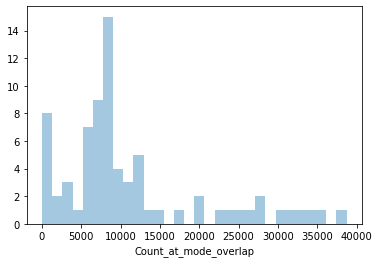

In [12]:
import pandas as pd
import seaborn as sns
%matplotlib inline

df = pd.read_csv('merged_16SrRNA_read_stas.tsv', sep='\t',index_col=0)
sns.distplot(df.Count_at_mode_overlap,kde=False,bins=30)

### Import merged reads to qiime2

In [13]:
!qiime tools import \
  --type 'SampleData[SequencesWithQuality]' \
  --input-path merged/16SrRNA \
  --input-format CasavaOneEightSingleLanePerSampleDirFmt \
  --output-path merged/16SrRNA/demux.qza

/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Imported merged/16SrRNA as CasavaOneEightSingleLanePerSampleDirFmt to merged/16SrRNA/demux.qza


### Run DADA2

In [14]:
!mkdir dada/16SrRNA
!qiime dada2 denoise-single \
  --i-demultiplexed-seqs merged/16SrRNA/demux.qza \
  --p-trim-left 0 \
  --p-trunc-len 250 \
  --p-max-ee 5.0 \
  --o-representative-sequences dada/16SrRNA/rep-seqs.qza \
  --o-table dada/16SrRNA/table.qza \
  --o-denoising-stats dada/16SrRNA/stats.qza

mkdir: cannot create directory ‘dada/16SrRNA’: File exists
/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved FeatureTable[Frequency] to: dada/16SrRNA/table.qza
Saved FeatureData[Sequence] to: dada/16SrRNA/rep-seqs.qza
Saved SampleData[DADA2Stats] to: dada/16SrRNA/stats.qza


In [15]:
!qiime metadata tabulate \
  --m-input-file dada/16SrRNA/stats.qza \
  --o-visualization dada/16SrRNA/stats.qzv

/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved Visualization to: dada/16SrRNA/stats.qzv


### Assign taxonomy to ASVs

In [18]:
!wget https://data.qiime2.org/2020.8/common/silva-138-99-515-806-nb-classifier.qza -O DB/silva-138-99-515-806-nb-classifier.qza

--2020-12-27 08:35:31--  https://data.qiime2.org/2020.8/common/silva-138-99-515-806-nb-classifier.qza
Resolving data.qiime2.org (data.qiime2.org)... 52.35.38.247
Connecting to data.qiime2.org (data.qiime2.org)|52.35.38.247|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://s3-us-west-2.amazonaws.com/qiime2-data/2020.8/common/silva-138-99-515-806-nb-classifier.qza [following]
--2020-12-27 08:35:32--  https://s3-us-west-2.amazonaws.com/qiime2-data/2020.8/common/silva-138-99-515-806-nb-classifier.qza
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.209.24
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.209.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153517385 (146M) [binary/octet-stream]
Saving to: ‘DB/silva-138-99-515-806-nb-classifier.qza’

DB/silva-138-99-515 100%[===================>] 146.41M  4.06MB/s    in 51s     

2020-12-27 08:36:24 (2.86 MB/s) - ‘DB/silva-

In [19]:
!qiime feature-classifier classify-sklearn \
  --i-classifier DB/silva-138-99-515-806-nb-classifier.qza \
  --i-reads dada/16SrRNA/rep-seqs.qza \
  --o-classification dada/16SrRNA/taxonomy.qza

/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved FeatureData[Taxonomy] to: dada/16SrRNA/taxonomy.qza


### Make ASV tree

In [20]:
!qiime phylogeny align-to-tree-mafft-fasttree \
  --i-sequences dada/16SrRNA/rep-seqs.qza \
  --o-alignment dada/16SrRNA/aligned-rep-seqs.qza \
  --o-masked-alignment dada/16SrRNA/masked-aligned-rep-seqs.qza \
  --o-tree dada/16SrRNA/unrooted-tree.qza \
  --o-rooted-tree dada/16SrRNA/rooted-tree.qza

/home/amir/anaconda3/envs/qiime2-2020.8/lib/python3.6/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt
Saved FeatureData[AlignedSequence] to: dada/16SrRNA/aligned-rep-seqs.qza
Saved FeatureData[AlignedSequence] to: dada/16SrRNA/masked-aligned-rep-seqs.qza
Saved Phylogeny[Unrooted] to: dada/16SrRNA/unrooted-tree.qza
Saved Phylogeny[Rooted] to: dada/16SrRNA/rooted-tree.qza
